In [ ]:
import os
import random

import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.utils.data
from torch.utils.data import Dataset
import torch.optim as optim
from tqdm import tqdm
import sklearn

from sklearn import metrics
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

Define Helpers

In [10]:
def get_n_params(model):
    """ Function to count number of parameters in a model. """
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

# For reproducibility
def seed_everything(seed):
    """ Seeds all relevant random generators to the same value. """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    print('Manual seed changed successfully.')

seed = 42
seed_everything(seed)

Manual seed changed successfully.


###  Load Raw Data and Define Datasets

In [11]:
def load_data(train_batch_size, test_batch_size):
    trainset = datasets.MNIST('../Datasets/', train=True, download=True,
                               transform=transforms.Compose([
                               transforms.Resize((32, 32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))
                               ]))

    val_set_size = int(0.2 * len(trainset))
    trainset, valset = torch.utils.data.random_split(trainset, [len(trainset) - val_set_size, val_set_size])

    testset = datasets.MNIST('../Datasets', train=False,
                              transform=transforms.Compose([
                                  transforms.Resize((32, 32)),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))
                              ]))

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=train_batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=False)
    return trainset, train_loader, valset, val_loader, testset, test_loader

In [12]:
# load train data
train_batch_size = 64
test_batch_size = 1000

train_set, train_loader, val_set, val_loader, test_set, test_loader = load_data(train_batch_size, test_batch_size)
print(test_loader.dataset)

print(f'data shape: train {len(train_set)}, val {len(val_set)}, test {len(test_set)}')

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Datasets
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
data shape: train 48000, val 12000, test 10000


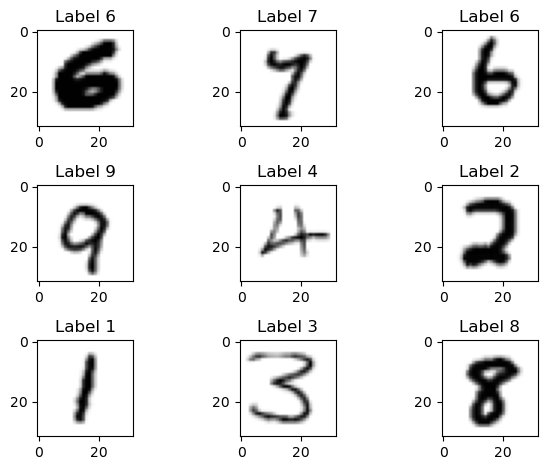

In [13]:
# Display some images
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(255 - train_set[i][0].squeeze(), cmap=plt.get_cmap('gray'))
    plt.title(f"Label {train_set[i][1]}")
plt.tight_layout()
plt.show()

### Model Definition

In [14]:
class CNN(nn.Module):
    def __init__(self, n_feat_maps):
        super(CNN, self).__init__()
        self.n_feat_maps = n_feat_maps
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feat_maps, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feat_maps, n_feat_maps, kernel_size=5)
        self.fc1 = nn.Linear(n_feat_maps*5*5, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        #### add the dropout here! ####
        x = F.dropout(x,0.5)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

In [17]:
# set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Working on: ', device)

total_train_accuracy, total_val_accuracy = [], []
total_train_loss, total_val_loss = [], []
criterion = torch.nn.CrossEntropyLoss()

def train(epoch, model):
    model.train()
    correct = 0
    loss_data = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss_data+=loss.data
        loss.backward()
        optimizer.step()
        preds = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += preds.eq(target.data.view_as(preds)).cpu().sum().item()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    accuracy = 100. * correct / len(train_loader.dataset)
    loss_data /= len(train_loader.dataset)
    total_train_accuracy.append(accuracy)
    total_train_loss.append(loss_data)

def eval(model):

    model.eval()
    val_loss = 0
    correct = 0

    for data, target in tqdm(val_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data  # sum up batch loss
        preds = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += preds.eq(target.data.view_as(preds)).cpu().sum().item()

    val_loss /= len(val_loader.dataset)
    accuracy = 100. * correct / len(val_loader.dataset)
    total_val_accuracy.append(accuracy)
    total_val_loss.append(val_loss)

    print('\nValidation set: average loss: {:.4f}, accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(test_loader.dataset),
        accuracy))
    return(total_val_loss,total_val_accuracy)

Working on:  cpu


### Train and Evaluate a Model

In [18]:
# define number of feature maps
n_feat_maps = 3

model_cnn = CNN(n_feat_maps)
model_cnn.to(device)

optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))
for epoch in range(0, 10):
    train(epoch, model_cnn)
    eval(model_cnn)

Number of parameters: 4616
Train Epoch: 0 [0/48000 (0%)]	Loss: 2.329001
Train Epoch: 0 [6400/48000 (13%)]	Loss: 1.839751
Train Epoch: 0 [12800/48000 (27%)]	Loss: 1.050304
Train Epoch: 0 [19200/48000 (40%)]	Loss: 1.035840
Train Epoch: 0 [25600/48000 (53%)]	Loss: 0.439586
Train Epoch: 0 [32000/48000 (67%)]	Loss: 0.539790
Train Epoch: 0 [38400/48000 (80%)]	Loss: 0.490637
Train Epoch: 0 [44800/48000 (93%)]	Loss: 0.391418


100%|██████████| 188/188 [00:09<00:00, 18.83it/s]



Validation set: average loss: 0.0072, accuracy: 10199/10000 (85%)

Train Epoch: 1 [0/48000 (0%)]	Loss: 0.488008
Train Epoch: 1 [6400/48000 (13%)]	Loss: 0.443879
Train Epoch: 1 [12800/48000 (27%)]	Loss: 0.317689
Train Epoch: 1 [19200/48000 (40%)]	Loss: 0.366764
Train Epoch: 1 [25600/48000 (53%)]	Loss: 0.253585
Train Epoch: 1 [32000/48000 (67%)]	Loss: 0.223439
Train Epoch: 1 [38400/48000 (80%)]	Loss: 0.513561
Train Epoch: 1 [44800/48000 (93%)]	Loss: 0.316018


100%|██████████| 188/188 [00:07<00:00, 25.86it/s]



Validation set: average loss: 0.0052, accuracy: 10788/10000 (90%)

Train Epoch: 2 [0/48000 (0%)]	Loss: 0.247800
Train Epoch: 2 [6400/48000 (13%)]	Loss: 0.375516
Train Epoch: 2 [12800/48000 (27%)]	Loss: 0.350064
Train Epoch: 2 [19200/48000 (40%)]	Loss: 0.264458
Train Epoch: 2 [25600/48000 (53%)]	Loss: 0.236416
Train Epoch: 2 [32000/48000 (67%)]	Loss: 0.156065
Train Epoch: 2 [38400/48000 (80%)]	Loss: 0.328958
Train Epoch: 2 [44800/48000 (93%)]	Loss: 0.260034


100%|██████████| 188/188 [00:10<00:00, 17.68it/s]



Validation set: average loss: 0.0041, accuracy: 11027/10000 (92%)

Train Epoch: 3 [0/48000 (0%)]	Loss: 0.140996
Train Epoch: 3 [6400/48000 (13%)]	Loss: 0.222130
Train Epoch: 3 [12800/48000 (27%)]	Loss: 0.382877
Train Epoch: 3 [19200/48000 (40%)]	Loss: 0.381185
Train Epoch: 3 [25600/48000 (53%)]	Loss: 0.141577
Train Epoch: 3 [32000/48000 (67%)]	Loss: 0.304101
Train Epoch: 3 [38400/48000 (80%)]	Loss: 0.346185
Train Epoch: 3 [44800/48000 (93%)]	Loss: 0.257832


100%|██████████| 188/188 [00:07<00:00, 24.19it/s]



Validation set: average loss: 0.0038, accuracy: 11090/10000 (92%)

Train Epoch: 4 [0/48000 (0%)]	Loss: 0.199627
Train Epoch: 4 [6400/48000 (13%)]	Loss: 0.126030
Train Epoch: 4 [12800/48000 (27%)]	Loss: 0.242043
Train Epoch: 4 [19200/48000 (40%)]	Loss: 0.169475
Train Epoch: 4 [25600/48000 (53%)]	Loss: 0.273001
Train Epoch: 4 [32000/48000 (67%)]	Loss: 0.221098
Train Epoch: 4 [38400/48000 (80%)]	Loss: 0.134811
Train Epoch: 4 [44800/48000 (93%)]	Loss: 0.355345


100%|██████████| 188/188 [00:07<00:00, 26.73it/s]



Validation set: average loss: 0.0035, accuracy: 11177/10000 (93%)

Train Epoch: 5 [0/48000 (0%)]	Loss: 0.097302
Train Epoch: 5 [6400/48000 (13%)]	Loss: 0.243709
Train Epoch: 5 [12800/48000 (27%)]	Loss: 0.218312
Train Epoch: 5 [19200/48000 (40%)]	Loss: 0.210781
Train Epoch: 5 [25600/48000 (53%)]	Loss: 0.163244
Train Epoch: 5 [32000/48000 (67%)]	Loss: 0.147319
Train Epoch: 5 [38400/48000 (80%)]	Loss: 0.161699
Train Epoch: 5 [44800/48000 (93%)]	Loss: 0.099348


100%|██████████| 188/188 [00:07<00:00, 25.28it/s]



Validation set: average loss: 0.0033, accuracy: 11207/10000 (93%)

Train Epoch: 6 [0/48000 (0%)]	Loss: 0.134579
Train Epoch: 6 [6400/48000 (13%)]	Loss: 0.180440
Train Epoch: 6 [12800/48000 (27%)]	Loss: 0.207957
Train Epoch: 6 [19200/48000 (40%)]	Loss: 0.237784
Train Epoch: 6 [25600/48000 (53%)]	Loss: 0.120564
Train Epoch: 6 [32000/48000 (67%)]	Loss: 0.174814
Train Epoch: 6 [38400/48000 (80%)]	Loss: 0.071009
Train Epoch: 6 [44800/48000 (93%)]	Loss: 0.152988


100%|██████████| 188/188 [00:07<00:00, 24.73it/s]



Validation set: average loss: 0.0033, accuracy: 11224/10000 (94%)

Train Epoch: 7 [0/48000 (0%)]	Loss: 0.059404
Train Epoch: 7 [6400/48000 (13%)]	Loss: 0.205472
Train Epoch: 7 [12800/48000 (27%)]	Loss: 0.239394
Train Epoch: 7 [19200/48000 (40%)]	Loss: 0.084896
Train Epoch: 7 [25600/48000 (53%)]	Loss: 0.108968
Train Epoch: 7 [32000/48000 (67%)]	Loss: 0.234573
Train Epoch: 7 [38400/48000 (80%)]	Loss: 0.228192
Train Epoch: 7 [44800/48000 (93%)]	Loss: 0.142295


100%|██████████| 188/188 [00:06<00:00, 27.73it/s]



Validation set: average loss: 0.0030, accuracy: 11280/10000 (94%)

Train Epoch: 8 [0/48000 (0%)]	Loss: 0.230440
Train Epoch: 8 [6400/48000 (13%)]	Loss: 0.306041
Train Epoch: 8 [12800/48000 (27%)]	Loss: 0.163728
Train Epoch: 8 [19200/48000 (40%)]	Loss: 0.144356
Train Epoch: 8 [25600/48000 (53%)]	Loss: 0.125018
Train Epoch: 8 [32000/48000 (67%)]	Loss: 0.235307
Train Epoch: 8 [38400/48000 (80%)]	Loss: 0.253602
Train Epoch: 8 [44800/48000 (93%)]	Loss: 0.129399


100%|██████████| 188/188 [00:06<00:00, 27.40it/s]



Validation set: average loss: 0.0031, accuracy: 11243/10000 (94%)

Train Epoch: 9 [0/48000 (0%)]	Loss: 0.079846
Train Epoch: 9 [6400/48000 (13%)]	Loss: 0.252427
Train Epoch: 9 [12800/48000 (27%)]	Loss: 0.239046
Train Epoch: 9 [19200/48000 (40%)]	Loss: 0.147662
Train Epoch: 9 [25600/48000 (53%)]	Loss: 0.181181
Train Epoch: 9 [32000/48000 (67%)]	Loss: 0.118673
Train Epoch: 9 [38400/48000 (80%)]	Loss: 0.200436
Train Epoch: 9 [44800/48000 (93%)]	Loss: 0.068611


100%|██████████| 188/188 [00:06<00:00, 27.01it/s]


Validation set: average loss: 0.0030, accuracy: 11287/10000 (94%)



In [19]:
print(total_val_loss,total_val_accuracy,total_train_accuracy,total_train_loss)

[tensor(0.0072), tensor(0.0052), tensor(0.0041), tensor(0.0038), tensor(0.0035), tensor(0.0033), tensor(0.0033), tensor(0.0030), tensor(0.0031), tensor(0.0030)] [84.99166666666666, 89.9, 91.89166666666667, 92.41666666666667, 93.14166666666667, 93.39166666666667, 93.53333333333333, 94.0, 93.69166666666666, 94.05833333333334] [71.46875, 89.22083333333333, 91.225, 92.38541666666667, 92.86666666666666, 93.4, 93.82291666666667, 93.89583333333333, 94.26041666666667, 94.31875] [tensor(0.0134), tensor(0.0055), tensor(0.0044), tensor(0.0038), tensor(0.0035), tensor(0.0033), tensor(0.0030), tensor(0.0030), tensor(0.0028), tensor(0.0028)]


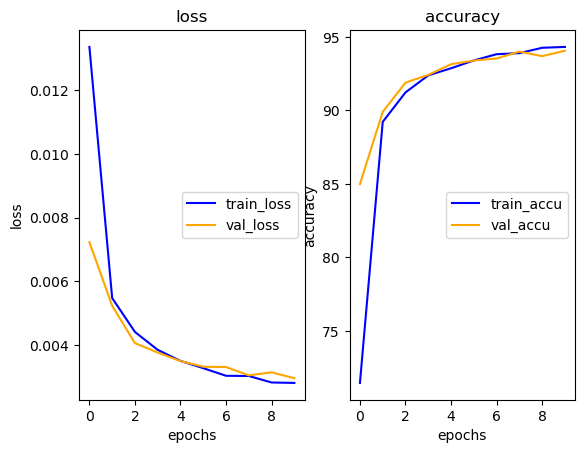

In [24]:
""" Add your code and plot a convergence graph here """
fig , axes =plt.subplots(nrows=1,ncols=2)
axes[0].plot(range(0, 10), total_train_loss, '-',color='blue')
axes[0].plot(range(0, 10), total_val_loss,'-', color='orange')
axes[0].legend(['train_loss', 'val_loss'],loc='center right')
axes[0].title.set_text('loss')
axes[0].set(xlabel='epochs', ylabel='loss')


axes[1].plot(range(0, 10), total_train_accuracy, '-',color = 'blue')
axes[1].plot(range(0, 10),total_val_accuracy,'-', color='orange')
axes[1].legend(['train_accu', 'val_accu'],loc='center right')
plt.title('accuracy')
axes[1].set(xlabel='epochs', ylabel='accuracy')
plt.show()

### Inference

In [89]:
""" Make predictions here """
def salomon_prediction(model,part):
    predictions = []
    model.eval #like that we are not including the drop out layer
    for data, target in tqdm(part):
        data, target = data.to(device), target.to(device)
        output = model(data)
        preds = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        predictions.append(preds)
    return(predictions)

In [90]:
preds_test = salomon_prediction(model_cnn,test_loader)
preds_val = salomon_prediction(model_cnn,val_loader)

100%|██████████| 188/188 [00:07<00:00, 25.42it/s]


In [91]:
def flatten(list_of_tensor):
    a = np.concatenate(list_of_tensor).flat
    flatten_list = list(a)
    return(flatten_list)

In [115]:
def get_targets(tensor):
    val_set_targets = []
    for item in range(0,len(tensor)):
        val_set_targets.append(tensor[item][1])
    return val_set_targets

In [121]:
#preparation of the data for the cm
flat_preds_test = flatten(preds_test)
flat_preds_val = flatten(preds_val)
val_set_targets = get_targets(val_set)

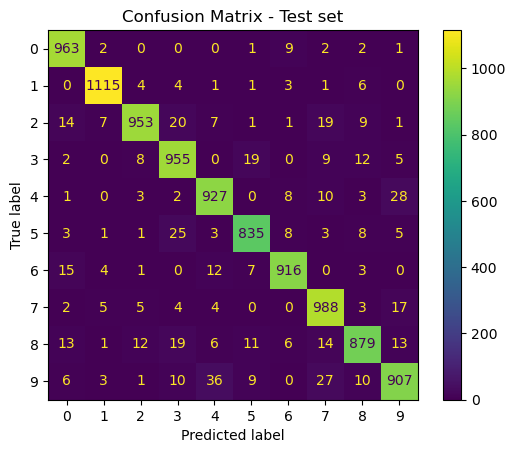

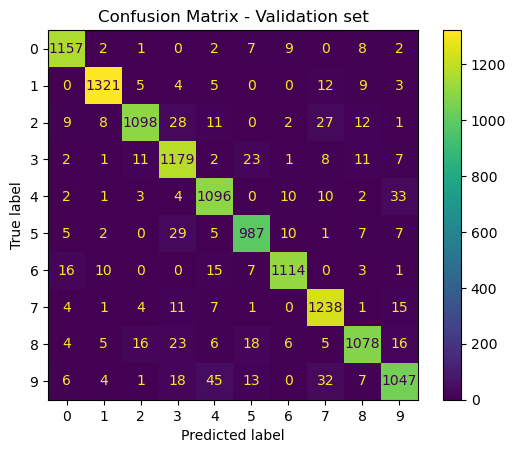

In [129]:
""" Plot confusion Matrix """
cm1_display = metrics.ConfusionMatrixDisplay(confusion_matrix = metrics.confusion_matrix(test_set.targets, flat_preds_test),display_labels = list(range(0,10)))
cm1_display.plot()
plt.title('Confusion Matrix - Test set')
plt.show()

cm2_metrics = ConfusionMatrixDisplay(confusion_matrix = metrics.confusion_matrix(val_set_targets,flat_preds_val),display_labels = list(range(0,10)))
cm2_metrics.plot()
plt.title('Confusion Matrix - Validation set')
plt.show()

In [ ]:
print(f"the confusion matrix give different result ,the result were better on the validation set that lead me to suppose that the model make an overfit of the data then his accuracy is lower when he look and a dataset that he don't know")
print(f"but when we had the dropout layer the gap between the confusion matrix decrease ,that prove that if we train our model in a way that we ask him to forget some of the weigth at some step it's improve his capacity with unknown data ")
